In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py
import random
import cv2

from keras.models import Sequential, Model,load_model
from keras.layers import Dense, Flatten, Reshape, Conv2D, MaxPool2D, Conv2DTranspose, BatchNormalization, Dropout, LeakyReLU
from keras.optimizers import Adam, SGD
from keras.losses import MeanSquaredError
from keras import activations

from sklearn.preprocessing import MinMaxScaler




from tensorflow.keras import utils
import tensorflow as tf
tf.config.run_functions_eagerly(True)
tf.data.experimental.enable_debug_mode()


F:\MiniConda\envs\tf\lib\site-packages\h5py\__init__.py:36: UserWarning: h5py is running against HDF5 1.12.2 when it was built against 1.12.1, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


In [ ]:
# with h5py.File('Galaxy10_DECals.h5', 'r') as h5_file:
#     # Odczytaj dane ze zbiorów danych
#     ans_data = h5_file['ans'][:]
#     dec_data = h5_file['dec'][:]
#     images_data = h5_file['images'][:]
#     pxscale_data = h5_file['pxscale'][:]
#     ra_data = h5_file['ra'][:]
#     redshift_data = h5_file['redshift'][:]

# # Tworzenie DataFrame z danymi
# data_dict = {
#     'ans': ans_data,
#     'dec': dec_data,
#     'images': images_data,
#     'pxscale': pxscale_data,
#     'ra': ra_data,
#     'redshift': redshift_data
# }

# df = pd.DataFrame(data_dict)

In [3]:
%%time
# # To get the images and labels from file
with h5py.File('../Galaxy10_DECals.h5', 'r') as F:
    images = np.array(F['images'])
    labels = np.array(F['ans'])

# To convert the labels to categorical 10 classes
labels = utils.to_categorical(labels, 10)

# To convert to desirable type
labels = labels.astype(np.float32)
images = images.astype(np.float32)
labels_names = ["Disturbed Galaxies", "Merging Galaxies", "Round Smooth Galaxies", "In-between Round Smooth Galaxies", "Cigar Shaped Smooth Galaxies",
            "Barred Spiral Galaxies", "Unbarred Tight Spiral Galaxies", "Unbarred Loose Spiral Galaxies", "Edge-on Galaxies without Bulge", "Edge-on Galaxies with Bulge"]

CPU times: total: 51.7 s
Wall time: 1min 8s


In [4]:
for name, count in zip(labels_names, np.unique(labels[:,:], axis=0, return_counts=True)[1]):
    print(f"{name}: {count}")

Disturbed Galaxies: 1873
Merging Galaxies: 1423
Round Smooth Galaxies: 2628
In-between Round Smooth Galaxies: 1829
Cigar Shaped Smooth Galaxies: 2043
Barred Spiral Galaxies: 334
Unbarred Tight Spiral Galaxies: 2027
Unbarred Loose Spiral Galaxies: 2645
Edge-on Galaxies without Bulge: 1853
Edge-on Galaxies with Bulge: 1081


[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


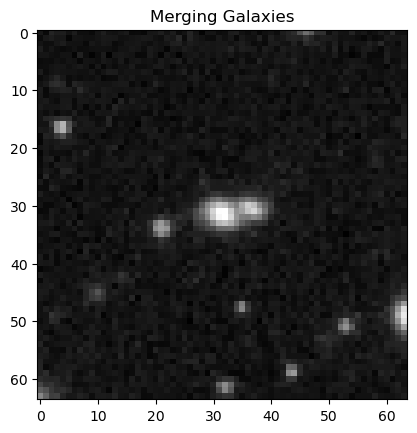

In [23]:
def show_image(index):
    plt.imshow(images[index].astype(np.int16), cmap="gray")
    plt.title(labels_names[np.where(labels[index] == 1)[0][0]])
    print(labels[index])
    plt.show()


show_image(1103)

In [14]:
%%time
images = tf.image.resize(images, (64, 64))
images = tf.image.rgb_to_grayscale(images)
images = images.numpy()

In [24]:
scaler = MinMaxScaler()
images = scaler.fit_transform(images.reshape(-1, 64*64))
images = images * 2 - 1
images = images.reshape(-1, 64, 64)

# Model

In [91]:
tf.random.set_seed(42)
np.random.seed(42)

codings_size = 100

generator = Sequential([
    Conv2DTranspose(filters=512, kernel_size=4, strides=1, padding="valid", activation=LeakyReLU(0.2), input_shape=[1, 1, codings_size]),
    BatchNormalization(),
    Conv2DTranspose(filters=512, kernel_size=4, strides=2, padding="same", activation=LeakyReLU(0.2)),
    BatchNormalization(),
    Conv2DTranspose(filters=256, kernel_size=4, strides=2, padding="same", activation=LeakyReLU(0.2)),
    BatchNormalization(),
    Conv2DTranspose(filters=128, kernel_size=4, strides=2, padding="same", activation=LeakyReLU(0.2)),
    BatchNormalization(),
    Conv2DTranspose(filters=1, kernel_size=4, strides=2, padding="same", activation="tanh"),
])

# discriminator = Sequential([
#     Conv2D(filters=512, kernel_size=(4,4), strides=1, padding="SAME", activation=LeakyReLU(0.2), input_shape=[28, 28, 1]),
#     Dropout(0.4),
#     Conv2D(128, kernel_size=5, strides=2, padding="SAME",activation=LeakyReLU(0.2)),
#     Dropout(0.4),
#     Flatten(),
#     Dense(1, activation="sigmoid")
# ])

# with tf.device('/GPU:0'):
#     gan = Sequential([generator, discriminator])

In [92]:
generator.summary()

Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_transpose_176 (Conv  (None, 4, 4, 512)         819712    
 2DTranspose)                                                    
                                                                 
 batch_normalization_140 (B  (None, 4, 4, 512)         2048      
 atchNormalization)                                              
                                                                 
 conv2d_transpose_177 (Conv  (None, 8, 8, 512)         4194816   
 2DTranspose)                                                    
                                                                 
 batch_normalization_141 (B  (None, 8, 8, 512)         2048      
 atchNormalization)                                              
                                                                 
 conv2d_transpose_178 (Conv  (None, 16, 16, 256)     

In [6]:
import sys
def sizeof_fmt(num, suffix='B'):
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name, value in list(
                          locals().items())), key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

                        images: 13.0 GiB
                        labels: 692.9 KiB
                    Sequential:  1.0 KiB
                         Model:  1.0 KiB
                         Dense:  1.0 KiB
                       Flatten:  1.0 KiB
                       Reshape:  1.0 KiB
                        Conv2D:  1.0 KiB
                     MaxPool2D:  1.0 KiB
               Conv2DTranspose:  1.0 KiB


Disturbed Galaxies: 1873
Merging Galaxies: 1423
Round Smooth Galaxies: 2628
In-between Round Smooth Galaxies: 1829
Cigar Shaped Smooth Galaxies: 2043
Barred Spiral Galaxies: 334
Unbarred Tight Spiral Galaxies: 2027
Unbarred Loose Spiral Galaxies: 2645
Edge-on Galaxies without Bulge: 1853
Edge-on Galaxies with Bulge: 1081


In [126]:
labels

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)